In [1]:
import metalearning_benchmarks.line_sine1d_benchmark
import torch
import wandb
from config import Config, DataConfig, ModelConfig, TrainValConfig
from decoder import Decoder
from deterministic_encoder import DeterministicEncoder
from diffusion_process import DIS
from encoder import Encoder
from latent_encoder import LatentEncoder, z_tuple
from matplotlib import pyplot as plt
from metalearning_benchmarks.line_sine1d_benchmark import LineSine1D
from neural_process import NeuralProcess
from train_val import train_and_validate
from utils import DataModule, MetaLearningDataset, split_context_target
from visualize import visualize_batch_1d

In [2]:
device = None

try:
    import torch_directml
    device = torch_directml.device()
except ModuleNotFoundError:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
print(device)

privateuseone:0


In [3]:
data_config = DataConfig(
    benchmark="LineSine1D",
    n_task=4096,
    n_datapoints_per_task=64,
    output_noise=0.1,
    seed_task=1237, 
    seed_x=123, 
    seed_noise=1237
)

model_config = ModelConfig(
    x_dim=1,
    y_dim=1,
    r_dim=2,
    z_dim=2,
    h_dim=128,
    num_layers_det_enc=3,
    num_layers_lat_enc=3,
    num_layers_dec=3,
    non_linearity="SiLU",
    is_attentive=False,
    aggregation="mean",
    fixed_start_density=True,
    diffusion_process="DIS",
    num_steps=16,
    num_layers_diffu_process=3,
)

train_val_config = TrainValConfig(
    batch_size=128,
    num_epochs=100,
    learning_rate=3e-5,
    split=(0.8, 0.2)
)

config = Config(
    data_config=data_config,
    model_config=model_config,
    train_val_config=train_val_config
)

In [4]:
benchmark = getattr(metalearning_benchmarks.line_sine1d_benchmark, config.data_config.benchmark)(
    n_task=config.data_config.n_task,
    n_datapoints_per_task=config.data_config.n_datapoints_per_task,
    output_noise=config.data_config.output_noise,
    seed_task=config.data_config.seed_task, 
    seed_x=config.data_config.seed_x, 
    seed_noise=config.data_config.seed_noise,
)

dataset = MetaLearningDataset(benchmark)

data_module = DataModule(
    batch_size=config.train_val_config.batch_size,
    dataset_and_split=(dataset, config.train_val_config.split),
    num_workers=15
)

Generating tasks: 100%|██████████| 4096/4096 [00:00<00:00, 279975.70it/s]


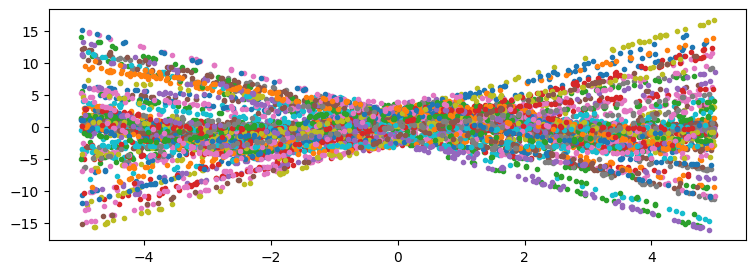

In [5]:
visualize_batch_1d(batch=next(iter(data_module.train_dataloader())))

In [6]:
diffu_process = DIS(
    device=device,
    num_steps=config.model_config.num_steps,
    z_dim=config.model_config.z_dim,
    h_dim=config.model_config.h_dim,
    num_layers=config.model_config.num_layers_diffu_process,
    non_linearity=config.model_config.non_linearity
)

# det_encoder = DeterministicEncoder(
#     x_dim=config.model_config.x_dim,
#     y_dim=config.model_config.y_dim,
#     h_dim=config.model_config.h_dim,
#     r_dim=config.model_config.r_dim,
#     num_layers=config.model_config.num_layers_det_enc,
#     non_linearity=config.model_config.non_linearity,
#     is_attentive=config.model_config.is_attentive,
#     aggregation=config.model_config.aggregation
# )

lat_enc = LatentEncoder(
    x_dim=config.model_config.x_dim,
    y_dim=config.model_config.y_dim,
    h_dim=config.model_config.h_dim,
    z_dim=config.model_config.z_dim,
    num_layers=config.model_config.num_layers_lat_enc,
    non_linearity=config.model_config.non_linearity,
    is_attentive=config.model_config.is_attentive,
    aggregation=config.model_config.aggregation,
    diffusion_process=diffu_process,
    fixed_start_density=config.model_config.fixed_start_density
)

enc = Encoder(
    deterministic_encoder=None, # det_encoder,
    latent_encoder=lat_enc
)

dec = Decoder(
    input_dim=config.model_config.x_dim + config.model_config.z_dim, # + config.model_config.r_dim,
    h_dim=config.model_config.h_dim,
    y_dim=config.model_config.y_dim,
    num_layers=config.model_config.num_layers_dec,
    non_linearity=config.model_config.non_linearity
)

neural_process = NeuralProcess(
    encoder=enc,
    decoder=dec,
).to(device)

optimizer = torch.optim.Adam(neural_process.parameters(), lr=config.train_val_config.learning_rate)

In [7]:
wandb_logging = True
if wandb_logging:
    wandb.init(project="np", config=config.asdict())

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: max-burzer (max-burzer-karlsruhe-institute-of-technology). Use `wandb login --relogin` to force relogin


In [8]:
avg_train_log_likes = []
avg_train_priors_kls = []
avg_train_diffu_kls = []

avg_val_log_likes = []
avg_val_priors_kls = []
avg_val_diffu_loss = []

In [13]:
losses = train_and_validate(
    neural_process=neural_process,
    device=device,
    data_module=data_module,
    optimizer=optimizer,
    num_epochs=config.train_val_config.num_epochs,
    wandb_logging=wandb_logging,
)

avg_train_log_likes.extend(losses[0])
avg_train_priors_kls.extend(losses[1])
avg_train_diffu_kls.extend(losses[2])

if losses[3] is not None: avg_val_log_likes.extend(losses[3])
if losses[4] is not None: avg_val_priors_kls.extend(losses[4])
if losses[5] is not None: avg_val_diffu_loss.extend(losses[5])

100%|██████████| 26/26 [00:11<00:00,  2.34it/s, diffu_kl=42, epoch=99, log_like=-173, loss=215, priors_kl=0]  


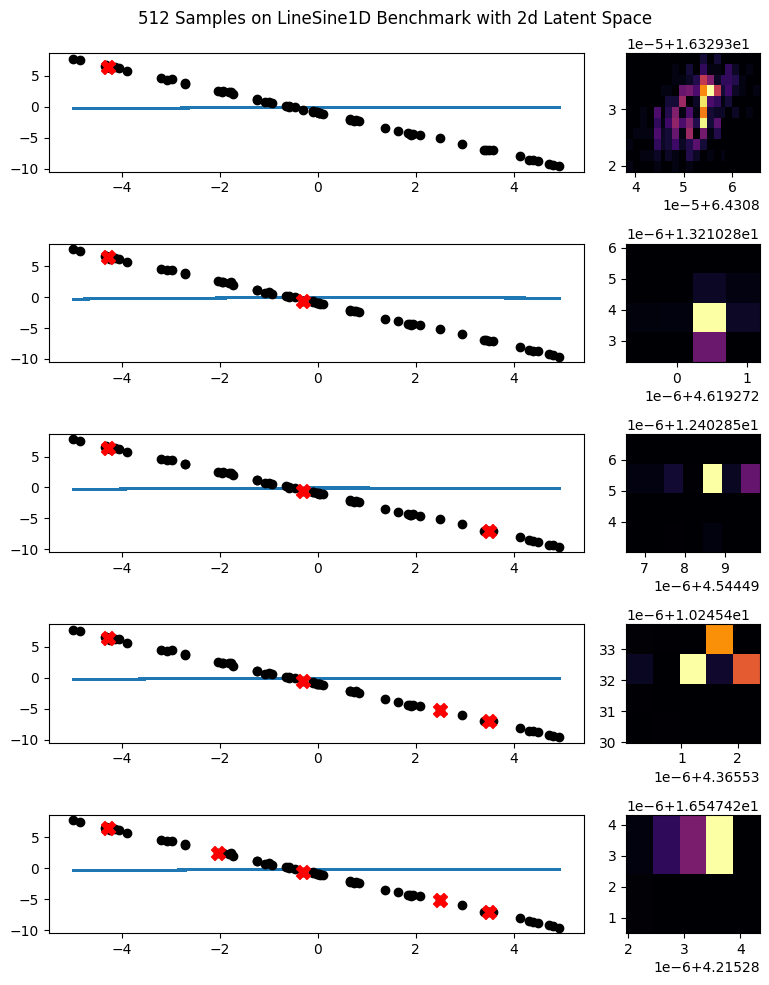

In [14]:
gen_dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=1, shuffle=True)
x_data, y_data = next(iter(gen_dataloader))
x_data = x_data.to(device)
y_data = y_data.to(device)

context_lens = [1, 2, 3, 4, 5] # x_data.shape[1] - 1

n_samples = 512

fig, ax  = plt.subplots(len(context_lens), 2, figsize=(8, 2 * len(context_lens)), gridspec_kw={'width_ratios': [4, 1]})
fig.suptitle(f"{n_samples} Samples on {config.data_config.benchmark} Benchmark with 2d Latent Space")

for i, context_len in enumerate(context_lens):

    x_context, y_context, _, _ = split_context_target(x_data, y_data, context_len=context_len, random=False)
    
    neural_process.eval()
    with torch.no_grad():
        
        _, y_mu, _, z_tuples = neural_process.sample(x_context, y_context, x_data, n_samples)

        x_data_sorted, indices = x_data.sort(dim=1)
        indices = indices.squeeze(0).squeeze(1)
        x_data_sorted = x_data_sorted.cpu().detach().numpy()
        y_data_sorted = y_data[:, indices, :].cpu().detach().numpy()
        y_mu_sorted = y_mu[:, indices, :].cpu().detach().numpy()

        for k in range(n_samples):
            ax[i][0].plot(x_data_sorted.squeeze(0).squeeze(1), y_mu_sorted[k].squeeze(1), alpha=0.2, c="tab:blue", zorder=0)

        ax[i][0].scatter(x_data_sorted, y_data_sorted, marker="o", c="black", zorder=1)
        ax[i][0].scatter(x_context.cpu().detach().numpy(), y_context.cpu().detach().numpy(), marker="X", c="red", s=100, zorder=2)

        ax[i][1].hist2d(z_tuples[-1].z[:, 0].cpu().detach().numpy(), z_tuples[-1].z[:, 1].cpu().detach().numpy(), bins=20, cmap="inferno")
        
        # ax[i][1].set_xlim(-10, 10)
        # ax[i][1].set_ylim(-10, 10)
        # if i != 0:
        #     ax[i][1].sharex(ax[0][1])
        #     ax[i][1].sharey(ax[0][1])


plt.tight_layout()
plt.show()